In [94]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

df = pl.read_csv("./dados_tratados.csv")

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(texts, ngram_range=(1, 2), max_features=2500, min_df=2, max_df=0.8):
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=min_df,
        max_df=max_df
    )
    X_tfidf = vectorizer.fit_transform(texts)
    return X_tfidf, vectorizer

In [ ]:
train_scores = []
val_scores = []

df_pandas = df.to_pandas()

X = df_pandas["texto"]
y = df_pandas["label"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=777)


X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=777) 
# 0.25 de 0.8 = 0.2 -> 60% train, 20% val, 20% test


X_train, vectorizer = tfidf(X_train)
X_test = vectorizer.transform(X_test)

X_train, vectorizer = tfidf(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
X_train_full = vectorizer.transform(X_train_full)

dtc = DecisionTreeClassifier(random_state=777)
path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = np.sort(ccp_alphas)[1:] 
sampled_alphas = np.linspace(np.min(ccp_alphas), np.max(ccp_alphas), 20)

for alpha in sampled_alphas:
    model = DecisionTreeClassifier(random_state=777, ccp_alpha=alpha)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    val_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(12,6))
plt.plot(sampled_alphas, train_scores, marker='o', label="Acuracia no Treino")
plt.plot(sampled_alphas, val_scores, marker='o', label="Acuracia no Teste")
plt.xlabel("ccp_alpha")
plt.ylabel("Acurácia")
plt.title("Poda da Árvore - Acurácia vs ccp_alpha")
plt.legend()

for i, alpha in enumerate(sampled_alphas):
    plt.text(alpha, val_scores[i], f"{alpha:.5f}", rotation=45, fontsize=8, ha='right')

plt.grid(True)
plt.show()

NameError: name 'df' is not defined

In [117]:
params = { 
    'max_depth': [5,7,10],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [10, 15],
    "ccp_alpha": [0.00280]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=777), param_grid=params,scoring=('accuracy'), cv=5, n_jobs=-1, verbose=2
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=15; total time=   0.4s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=15; total time=   0.5s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=15; total time=   0.4s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=15; total time=   0.5s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=15; total time=   0.5s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   0.5s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   0.5s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   0.5s
[CV] END ccp_alpha=0.0028, max_depth=5, min_samples_leaf=15, min_samples_split=15; total time=   0.3s
[CV] END ccp_alpha=0.

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=777),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0028], 'max_depth': [5, 7, 10],
                         'min_samples_leaf': [10, 15],
                         'min_samples_split': [15, 20]},
             scoring='accuracy', verbose=2)

In [118]:
model = grid.best_estimator_

print(f"Melhores Parâmetros: {grid.best_params_}")
print(f"E_in: {1 - model.score(X_train, y_train):.2f}")
print(f"E_out: {1 - model.score(X_test, y_test):.2f}")

y_pred = model.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, digits=3))

Melhores Parâmetros: {'ccp_alpha': 0.0028, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 15}
Acurácia no Treino: 0.81
Acurácia no Teste: 0.81
              precision    recall  f1-score   support

           0      0.785     0.958     0.863      3333
           1      0.883     0.546     0.675      1929

    accuracy                          0.807      5262
   macro avg      0.834     0.752     0.769      5262
weighted avg      0.821     0.807     0.794      5262



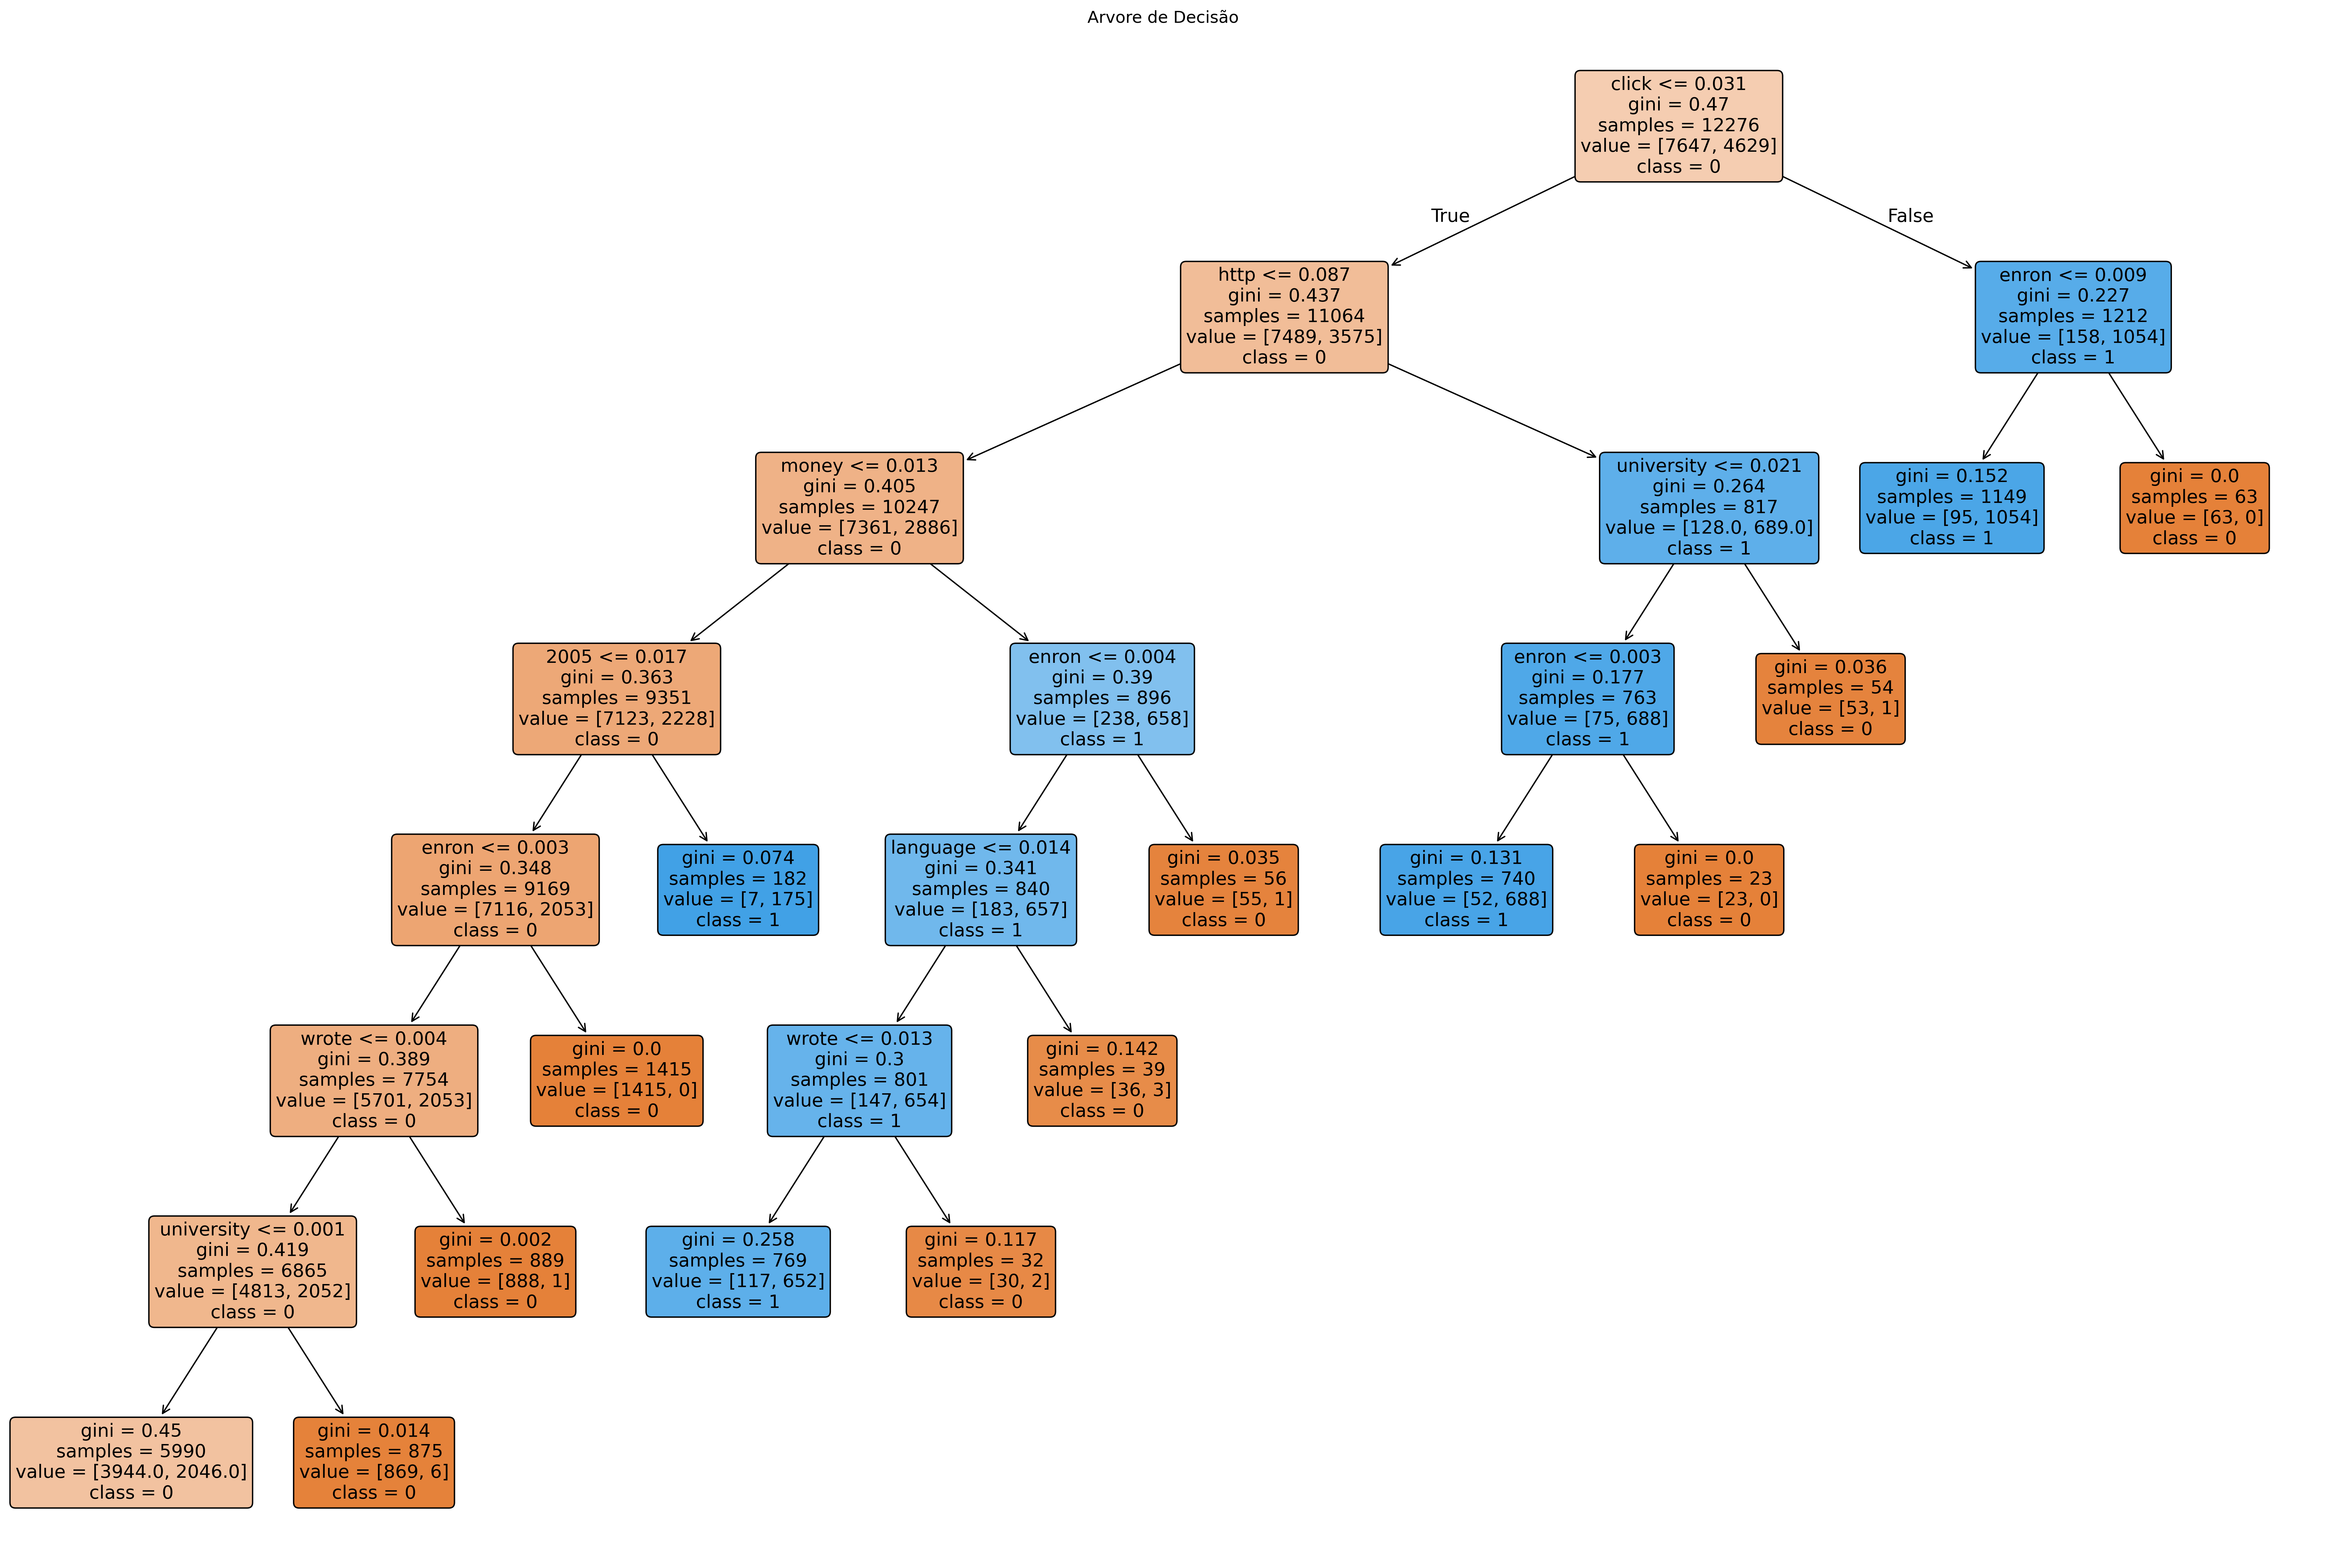

In [ ]:
plt.figure(figsize=(30, 20), dpi=300)

plot_tree(
    model, 
    feature_names=vectorizer.get_feature_names_out(),
    class_names=[str(c) for c in model.classes_],
    filled=True,
    rounded=True,
    max_depth=15
)

plt.title("Arvore de Decisão")
plt.show()
